In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import seaborn as sns

%matplotlib inline

# 1. Медианная цена по районам

**Посчитать медиану цены за кв.м. в продаже в Москве по районам города по предложениям, которые ушли с рынка в 2017 году**

Для этой части нам понадобится информация о сделках по продажам недвижимости за 2017 год, координаты домов и границы районов.

In [2]:
sell = pd.read_csv('/Users/AnnaLvova/Downloads/test_task_analytic/test_task/sell.msc.tsv', sep='\t')
houses = pd.read_csv('/Users/AnnaLvova/Downloads/test_task_analytic/houses.msc.tsv', sep='\t')
okrug = gpd.read_file('/Users/AnnaLvova/Downloads/test_task_analytic/msk_atd.geojson')

In [3]:
sell.head(3)

,offer_id,first_day_exposition,last_day_exposition,last_price,open_plan,rooms,studio,area,offer_type,category_type,is_premoderation,unified_address,price_period,last_exposition_year,price_per_sq_m,exposition_days
0,1321571849498624592,2014-11-27,2014-12-05,1.106557e+10,False,3,False,129.0,1,2,False,"Россия, Москва, Университетский проспект, 16",100,2014,857796.0,8
1,582350264413736779,2014-11-27,2014-12-10,1.353313e+10,False,5,False,191.8,1,2,False,"Россия, Москва, Университетский проспект, 16",100,2014,705585.0,13
2,582350263441210328,2014-11-27,2014-12-10,2.116756e+10,False,5,False,275.0,1,2,False,"Россия, Москва, Университетский проспект, 16",100,2014,769730.0,13


Оставим только те колонки, которые нам понадобятся: id предложения, адрес, год (2017) и цена за квадратный метр

In [4]:
sell_2 = sell[['offer_id','rooms', 'unified_address', 'last_exposition_year', 'price_per_sq_m']].copy()
sell_2 = sell_2[(sell_2['last_exposition_year']==2017)]

In [5]:
okrug = okrug[['id', 'name', 'name:en', 'geometry']].copy()
houses_coord = houses[['address','lat', 'lon']].copy()

Файл houses содержит координаты домов в Москве – к ним нужно будет привязать адреса из файлов sell и rent. Для начала проверим его на выбросы

In [7]:
houses_coord.info()
houses_coord.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77679 entries, 0 to 77678
Data columns (total 3 columns):
address    77679 non-null object
lat        77679 non-null float64
lon        77679 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.8+ MB


,address,lat,lon
0,"Россия, Москва",55.75154,37.534058
1,"Россия, Москва, 1-й Автозаводский проезд, 2",55.70473,37.655636
2,"Россия, Москва, 1-й Автозаводский проезд, 3",55.70522,37.656990


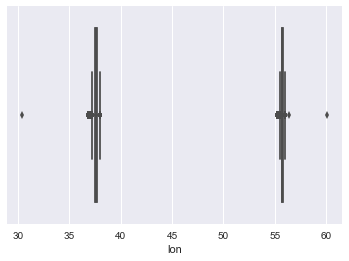

In [6]:
sns.boxplot(houses_coord['lat'])
sns.boxplot(houses_coord['lon'])

In [9]:
houses[houses['lat'] > 57]

,address,heatingType,hasSecurity,hasLift,floors,year,expectDemolition,ceilingHeight,hasGas,isGuarded,hasRubbishChute,porches,flats,lat,lon,metro_id,time_on_foot,series_name,building_type_str
36670,"Россия, Москва, Петровский бульвар, 12с1",NaN,NaN,NaN,19.0,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.05995,30.428741,20325.0,23.0,NaN,NaN


Выброс по координатам только один – по адресу Россия, Москва, Петровский бульвар, 12с1. 
В Москве действительно есть такой дом, но речь, скорее всего, не о нем. Во-первых, у этого дома 19 этажей, и год постройки отмечен как 2018 – это точно не про дом в историческом центре. Во-вторых, данные координаты приведут нас на Петровский бульвар, 12с1 в петербургском районе Девяткино. 

Поэтому сохраним этот адрес отдельно (возможно, он пропущен в аналогичном файле для Петербурга), и удалим его из файла houses_coord

In [10]:
outlier_from_spb = houses[houses.lat > 57]

In [11]:
houses_coord = houses_coord.drop(houses_coord[houses_coord.lat > 57].index)

Добавим координаты из файла houses_coord в таблицу sell

In [13]:
sell_3 = pd.merge(sell_2, houses_coord, how = 'left', left_on = 'unified_address', right_on = 'address')

Переведем данные в геоформат. Создаем GeoDataFrame из обычного DataFrame

In [14]:
geometry = [Point(xy) for xy in zip(sell_3.lon, sell_3.lat)]
df = sell_3.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_sell = GeoDataFrame(sell_3, crs=crs, geometry=geometry)

In [15]:
geo_sell.head(3)

,offer_id,rooms,unified_address,last_exposition_year,price_per_sq_m,address,lat,lon,geometry
0,5952756523340608496,4,"Россия, Москва, Университетский проспект, 16",2017,658120.0,"Россия, Москва, Университетский проспект, 16",55.71547,37.52111,POINT (37.52111 55.71547)
1,2916933856473180672,4,"Россия, Москва, Университетский проспект, 16",2017,496552.0,"Россия, Москва, Университетский проспект, 16",55.71547,37.52111,POINT (37.52111 55.71547)
2,5152206910293965497,0,"Россия, Москва, Университетский проспект, 16",2017,503597.0,"Россия, Москва, Университетский проспект, 16",55.71547,37.52111,POINT (37.52111 55.71547)


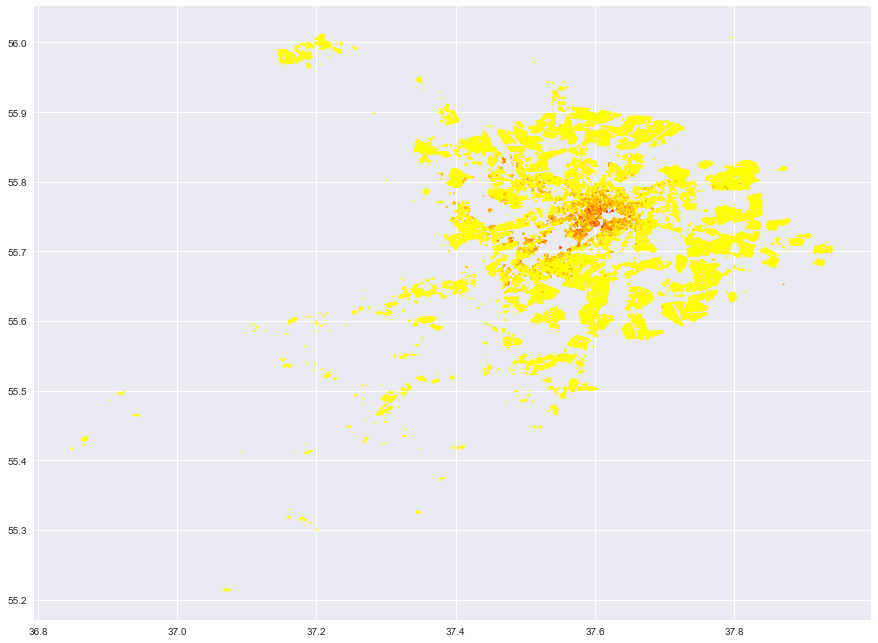

In [16]:
geo_sell.plot(column='price_per_sq_m', figsize=(15,15), markersize=2, cmap='autumn_r', scheme='fisher_jenks')

Для каждого объявления создадим колонку с районом/поселением, к которому он относится. 
Для этого проведем spatial join и создадим новый dataframe

In [17]:
sell_with_okrug = gpd.sjoin(geo_sell, okrug, how="inner", op='intersects')

In [18]:
sell_with_okrug.head(3)

,offer_id,rooms,unified_address,last_exposition_year,price_per_sq_m,address,lat,lon,geometry,index_right,id,name,name:en
0,5952756523340608496,4,"Россия, Москва, Университетский проспект, 16",2017,658120.0,"Россия, Москва, Университетский проспект, 16",55.71547,37.52111,POINT (37.52111 55.71547),48,relation/446115,район Раменки,Ramenki District
1,2916933856473180672,4,"Россия, Москва, Университетский проспект, 16",2017,496552.0,"Россия, Москва, Университетский проспект, 16",55.71547,37.52111,POINT (37.52111 55.71547),48,relation/446115,район Раменки,Ramenki District
2,5152206910293965497,0,"Россия, Москва, Университетский проспект, 16",2017,503597.0,"Россия, Москва, Университетский проспект, 16",55.71547,37.52111,POINT (37.52111 55.71547),48,relation/446115,район Раменки,Ramenki District


Посчитаем медианную цену

In [19]:
price_in_okrug = sell_with_okrug.groupby('name')['price_per_sq_m'].median()

Самая высокая медианная цена – в районах Хамовники, Арбат и Якиманка

In [21]:
price_in_okrug.sort_values(ascending=False).head(5)

name
район Хамовники        663984.0
район Арбат            652208.5
район Якиманка         571429.0
Пресненский район      457983.0
район Замоскворечье    452565.0
Name: price_per_sq_m, dtype: float64

In [ ]:
price_in_okrug.to_csv('../../price_in_okrug.tsv', sep='\t')

Добавим полученные значения в существующий датафрейм

In [22]:
okrug_with_sell = okrug.merge(price_in_okrug.reset_index(name='median_price'), left_on='name', right_on = 'name')

In [23]:
okrug_with_sell.head(3)

,id,name,name:en,geometry,median_price
0,relation/181288,район Внуково,Vnukovo District,"(POLYGON ((37.2169239 55.6218615, 37.2145561 5...",106432.0
1,relation/226927,район Кунцево,Kuntsevo District,"(POLYGON ((37.3786411 55.8083657, 37.3793921 5...",207664.5
2,relation/240229,район Крылатское,Krylatskoye District,"POLYGON ((37.4226197 55.7451629, 37.4235826 55...",228571.0


Дополнительно посмотрим на пространственное распределение данных

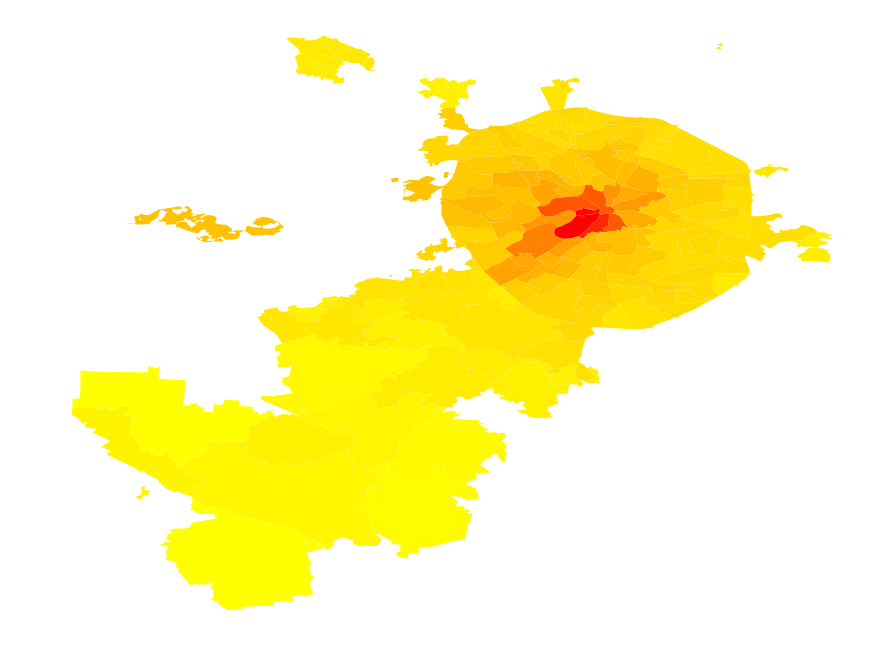

In [24]:
ax = okrug_with_sell.plot(column='median_price', figsize=(15,15), cmap='autumn_r')
ax.set_axis_off()

# 2. Медиана рентабельности покупки ради аренды

** Посчитать медиану рентабельности покупки квартиры в Москве с целью долгосрочной аренды (цена за кв. м. в продаже / цена за кв. м. в аренде)  по районам города по предложениям, которые ушли с рынка в 2017 году **

Чтобы посчитать price-to-rent ratio, воспользуемся медианными ценами покупки по районам, полученными в первой части задания. 
И аналогичным образом рассчитаем медианную стоимость квадратного метра в аренде

In [42]:
rent = pd.read_csv('/Users/AnnaLvova/Downloads/test_task_analytic/test_task/rent.msc.tsv', sep='\t')

In [43]:
rent.columns

Index(['offer_id', 'first_day_exposition', 'last_day_exposition', 'last_price',
       'open_plan', 'rooms', 'studio', 'area', 'offer_type', 'category_type',
       'is_premoderation', 'unified_address', 'price_period',
       'last_exposition_year', 'price_per_sq_m', 'exposition_days'],
      dtype='object')

In [44]:
rent_2 = rent[['offer_id', 'unified_address', 'last_exposition_year', 'price_per_sq_m']].copy()
rent_2 = rent_2[(rent_2['last_exposition_year']==2017)]

In [45]:
rent_3 = pd.merge(rent_2, houses_coord, how = 'left', left_on = 'unified_address', right_on = 'address')

In [29]:
geometry = [Point(xy) for xy in zip(rent_3.lon, rent_3.lat)]
df = rent_3.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_rent = GeoDataFrame(rent_3, crs=crs, geometry=geometry)

In [30]:
rent_with_okrug = gpd.sjoin(geo_rent, okrug, how="inner", op='intersects')

In [32]:
rent_in_okrug = rent_with_okrug.groupby('name')['price_per_sq_m'].median()
rent_in_okrug.sort_values(ascending=False).head(5)

name
район Арбат          1586.0
район Хамовники      1556.0
Пресненский район    1538.0
район Якиманка       1500.0
Тверской район       1478.5
Name: price_per_sq_m, dtype: float64

In [ ]:
rent_in_okrug.to_csv('../../price_in_okrug.tsv', sep='\t')

Получаем медианную стоимость аренды квадратного метра по районам

In [33]:
okrug_with_rent = okrug.merge(rent_in_okrug.reset_index(name='median_rent_price'), left_on='name', right_on = 'name')
okrug_final = okrug_with_rent.merge(price_in_okrug.reset_index(name='median_price'), left_on='name', right_on = 'name')

In [34]:
okrug_final.sort_values(by='median_rent_price')

,id,name,name:en,geometry,median_rent_price,median_price
138,relation/2092922,поселение Вороновское,,"POLYGON ((37.0545868 55.3989197, 37.052566 55....",368.0,84494.5
139,relation/2092924,поселение Клёновское,,"POLYGON ((37.4278176 55.3147269, 37.4238851 55...",375.0,72093.0
29,relation/445283,Молжаниновский район,Molzhaninovsky District,"POLYGON ((37.3764282 55.9554344, 37.3719719 55...",406.5,98182.0
134,relation/1693667,поселение Новофёдоровское,,"POLYGON ((36.9735128 55.3603249, 36.9749095 55...",466.0,62162.0
132,relation/1693596,поселение Киевский,,"(POLYGON ((36.9007522 55.3148568, 36.9012804 5...",466.0,89286.0
143,relation/2092931,поселение Щаповское,,"POLYGON ((37.2864341 55.3689397, 37.2856504 55...",488.0,75112.0
142,relation/2092929,поселение Рязановское,,"POLYGON ((37.4546266 55.4940783, 37.4545619 55...",500.0,98256.0
140,relation/2092925,поселение Краснопахорское,,"POLYGON ((37.2595482 55.3582701, 37.2591678 55...",511.0,87389.0
128,relation/1320510,район Силино,Silino District,"POLYGON ((37.1506438 55.9992264, 37.1580226 55...",522.0,113965.0
8,relation/380705,поселение Филимонковское,,"POLYGON ((37.4001073 55.5402845, 37.4015143 55...",525.0,92857.0


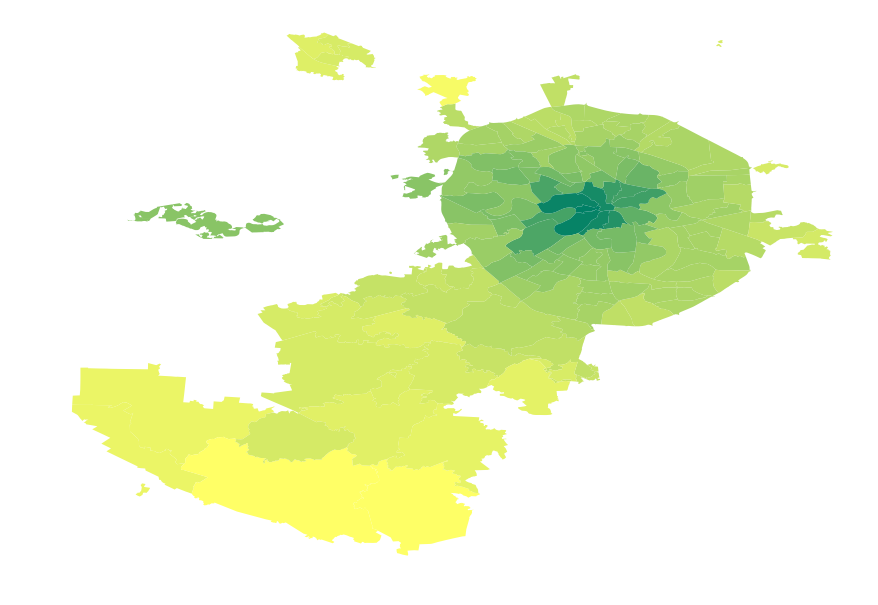

In [35]:
ax = okrug_final.plot(column='median_rent_price', figsize=(15,15), cmap='summer_r')
ax.set_axis_off()

In [36]:
okrug_final['PRratio'] = okrug_final['median_price']/(okrug_final['median_rent_price']*12)
okrug_final['PRratio'] = okrug_final['PRratio'].round(decimals=2)

In [40]:
okrug_final.sort_values(by='PRratio', ascending=True).head(3)

,id,name,name:en,geometry,median_rent_price,median_price,PRratio
134,relation/1693667,поселение Новофёдоровское,,"POLYGON ((36.9735128 55.3603249, 36.9749095 55...",466.0,62162.0,11.12
135,relation/1693672,поселение Первомайское,,"POLYGON ((37.3518053 55.5473838, 37.3513929 55...",567.5,79294.5,11.64
6,relation/380703,"поселение ""Мосрентген""",,"POLYGON ((37.4676604 55.6028483, 37.474246 55....",714.0,108889.0,12.71


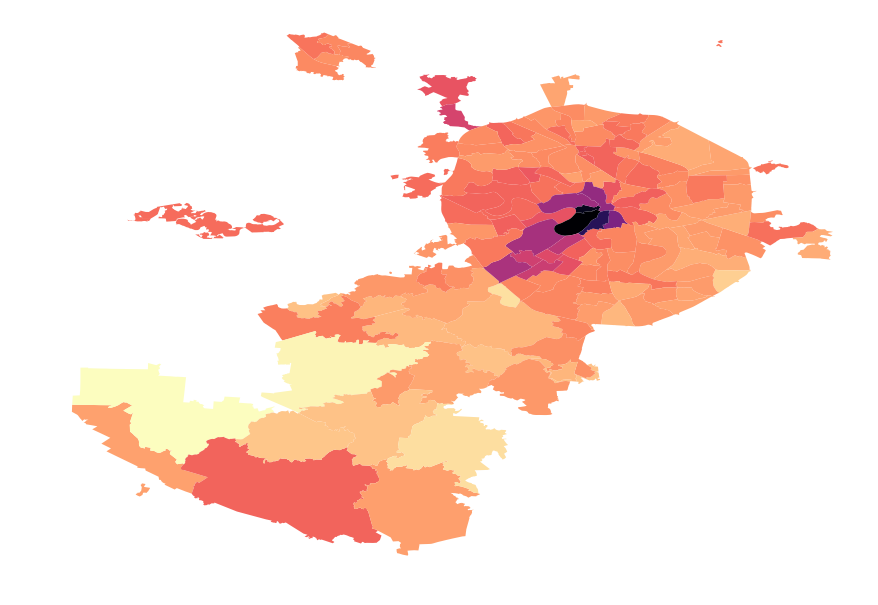

In [41]:
ax_2 = okrug_final.plot(column='PRratio', figsize=(15,15), cmap='magma_r')
ax_2.set_axis_off()

Вывод: 

Если покупать квартиру с целью долгосрочной аренды в Москве, то быстрее всего затраты окупятся в районах так называемой Новой Москвы. Отбить затраты на покупку квартиры в трех поселениях этой части столицы удастся меньше, чем за 13 с небольшим лет (без учета налогов, расходов на ее содаржание и пр). 

А вот покупка квартиры в трех самых дорогих районах Москвы (Хамовники, Арбат и Якиманка) оказалась самой невыгодной для сдачи в аренду. Арендные ставки там также самые высокие по городу, однако на карте с арендными ставками заметно, что по сравнению с соседними районами разница уже не так заметна. Соответственно крайне высокие цены на продажу именно в топ-трех районах Москвы приводят к тому, что затраты на покупку в случае долгосрочной аренды будут окупаться больше 30 лет.

# Часть 3. Тренды

### 3.1. Динамика спроса и предложения

Посмотрим, как менялся спрос на аренду и продажу квартир. Сравним, что пользуется большей популярностью – маленькие или большие квартиры.
В этом помогут сроки экспозиции объявлений (показатель 'exposition_days').
Для начала поймем разброс этого показателя – нарисуем ящики с усами для квартир с разным количеством комнат.

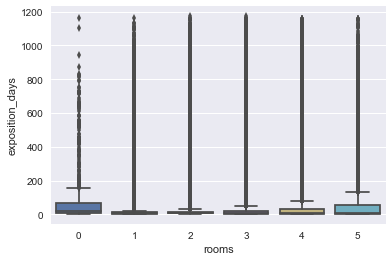

In [48]:
sns.boxplot(x='rooms', y='exposition_days', data=rent)

Аренда (график сверху)

Видим, что данные распределены асимметрично, поэтому для дальнейших расчетов будем использовать медианные значения, а не средние.
В то же время стоит помнить, что много значений находится за пределами верхнего квартиля, и медиана для всех типов квартир находится за пределами межквартильного размаха. 

Продажа (график снизу)

Интересно, что в Москве на продажу выставляются квартиры по 10, 20 и 30 комнат. Причем судя по адресам (в пределах городской черты) и метражу (вплоть до тысячи кв.м.), это реальные объявления. Впрочем их значение не так велико (322 квартиры более чем с 10 комнатами из 892 тысяч).
Распределение значений тоже неравномерно, поэтому использование медианы оправдано и в этом случае.

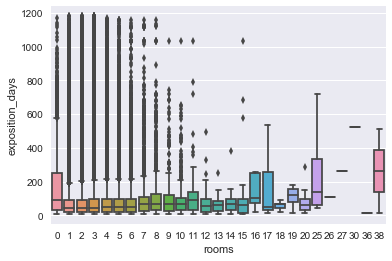

In [49]:
sns.boxplot(x='rooms', y='exposition_days', data=sell)

В 2016 году сдать многокомнатную квартиру в Москве стало в разы сложнее, чем в предыдущие 2 года. 
Медианный срок экспозиции 3-комнатной квартиры подскочил с 7 дней в 2015-м до 61 в 2016м, 4-комнатной – с 5 до 130 дней, 5-комнатной – с 5 до 144 дней. В 2017 году этот показатель скорректировался, но к значениям 2014-2015гг не вернулся. 

Это может быть связано либо с падением спроса, либо с резким увеличением предложения (проверим ниже).

Интересно, что однокомнатные квартиры практически не заметили этого "кризиса".

Однако если посчитать средние, а не медианные значения для этих же параметров, то резкий рост сроков экспозиции прочувствовали на себе и 1, 2-комнатные квартиры. Опять же это связано с выбросами  в данных:  очевидно, появилось какое-то количество простаивающих однушек и двушек, которые изменили общую картину.

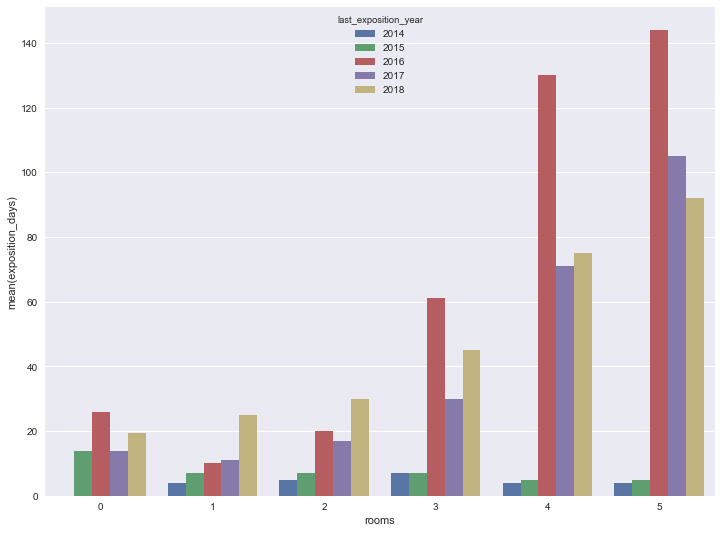

In [50]:
demand_rent = pd.DataFrame(
    rent.groupby(['rooms', 'last_exposition_year'])['exposition_days'].median()).reset_index()

fig, ax = plt.subplots(figsize=(12,9))
sns.factorplot(x='rooms', y='exposition_days', hue='last_exposition_year', 
               data=demand_rent, kind='bar', ax=ax
              )
plt.clf()

По сравнению с рынком аренды время продажи квартиры не так чувствительно к ее размеру: сроки экспозии соизмеримы для квартир от 1 до 5 комнат. 
При этом срок экспозиции поступательно растет в течение последних 5 лет. Так, если в 2014-м на продажу двушки уходило чуть больше двух недель, то в 2017-м на это стоило закладывать, как минимум, 3 месяца.

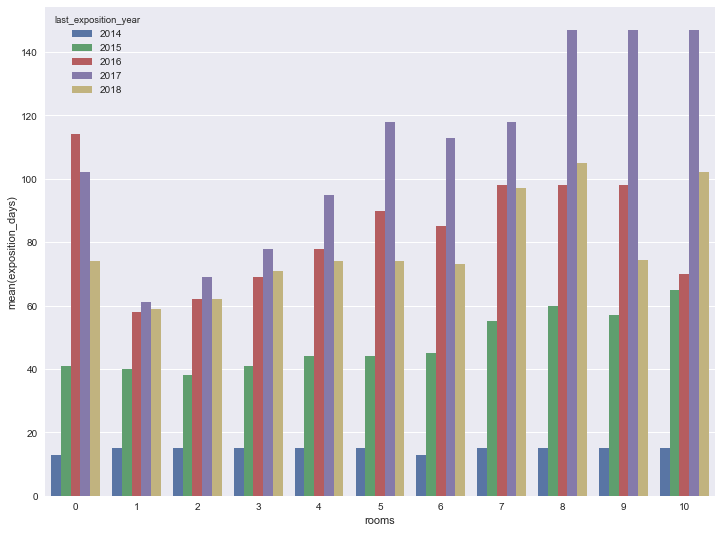

In [51]:
demand_sell = pd.DataFrame(
    sell[(sell['rooms']<11)].groupby(['rooms', 'last_exposition_year'])['exposition_days'].median()).reset_index()

fig, ax = plt.subplots(figsize=(12,9))
sns.factorplot(x='rooms', y='exposition_days', hue='last_exposition_year', 
               data=demand_sell[(demand_sell['rooms']<11)], kind='bar', ax=ax
              )
plt.clf()

Вернемся к гипотезе о резком увеличении предложения, возможно, ставшему причиной растянувшимся срокам размещения объявлений.
На графике отобразим количество предложений каждого типа квартир. Видим, что в 2015 году был всплекс, особенно у маленьких квартир (1 и 2 комнаты).

Интересно, что предложение выросло в сегменте однокомнатных, а срок экспозиции больше всего увеличился у многокомнатных. При этом время экспозиции однокомнатных, как уже отмечалось, выросло не так сильно. Это может указывать на перетекание спроса в сторону более экономного жилья: те, кто раньше рассчитывали на аренду большой квартиры, с 2016 переориентировались на более скромные варианты.

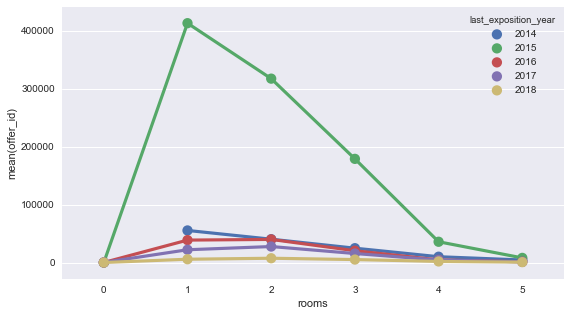

In [52]:
supply_rent = pd.DataFrame(
    rent.groupby(['rooms', 'last_exposition_year'])['offer_id'].count()).reset_index()

fig, ax = plt.subplots(figsize=(9,5))
sns.factorplot(x='rooms', y='offer_id', hue='last_exposition_year', 
               data=supply_rent, ax=ax
              )
plt.clf()

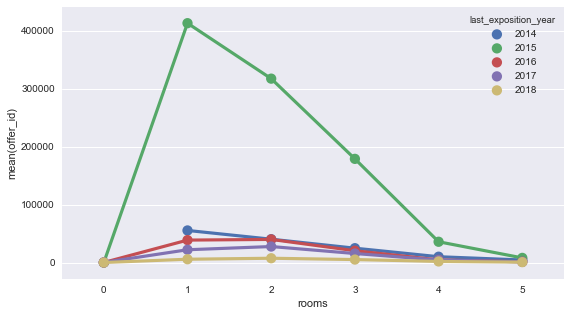

In [53]:
supply_sell = pd.DataFrame(
    rent.groupby(['rooms', 'last_exposition_year'])['offer_id'].count()).reset_index()

fig, ax = plt.subplots(figsize=(9,5))
sns.factorplot(x='rooms', y='offer_id', hue='last_exposition_year', 
               data=supply_sell, ax=ax
              )
plt.clf()

### 3.2. Объявление о программе сноса хрущевок 

21 февраля 2017 было объявлено о программе реновации в Москве. 2 мая появились первые списки под снос (4500 домов). Затем было голосование жильцов за или против сноса их дома.

Идея в том, чтобы посмотреть, как отразились эти действия на рынке недвижимости:
– стали ли москвичи пытаться продать свое жилье в ожидании программы реновации? То есть появился ли прирост объявлений в домах, где expectDemolition is True. 
– Как новости о реновации отразились на ценах? Они могли пойти вниз из-за непроясненной позиции мэрии о районах, куда будут переселять людей. С другой стороны, цены могли, напротив, вырости, так как реновация обещала улучшение жилищных условий

In [55]:
houses = pd.read_csv('/Users/AnnaLvova/Downloads/test_task_analytic/houses.msc.tsv', sep='\t')

Из 77,6 тысяч домов в базе (houses) у 4555 есть значения в колонке  expectDemolition. 
Из них 4068 – True (дом включен в программу реновации и будет снесен), 487 – False (дом попадал в первоначальный список, но его жители проголосовали против, поэтому он был исключен из программы). 

In [56]:
houses.groupby('expectDemolition').size()

expectDemolition
False     487
True     4068
dtype: int64

In [57]:
f =  {True: 'voted_yes', False: 'voted_no'}
houses['expectDemolition'].map(f).head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: expectDemolition, dtype: object

In [58]:
houses['expectDemolition'].fillna(0)

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
77649    0
77650    0
77651    0
77652    0
77653    0
77654    0
77655    0
77656    0
77657    0
77658    0
77659    0
77660    0
77661    0
77662    0
77663    0
77664    0
77665    0
77666    0
77667    0
77668    0
77669    0
77670    0
77671    0
77672    0
77673    0
77674    0
77675    0
77676    0
77677    0
77678    0
Name: expectDemolition, Length: 77679, dtype: object

In [59]:
houses_demol = houses[['address','expectDemolition', 'lat', 'lon']].copy()
houses_demol = houses_demol.drop(houses_demol[houses_demol.lat > 57].index)

In [60]:
sell_demol = sell[['offer_id', 'first_day_exposition','last_day_exposition', 'rooms', 'unified_address', 'last_exposition_year', 'exposition_days', 'price_per_sq_m']].copy()

In [61]:
sell_demol_coord = pd.merge(sell_demol, houses_demol, how = 'left', left_on = 'unified_address', right_on = 'address')

In [62]:
sell_demol_coord.head()

,offer_id,first_day_exposition,last_day_exposition,rooms,unified_address,last_exposition_year,exposition_days,price_per_sq_m,address,expectDemolition,lat,lon
0,1321571849498624592,2014-11-27,2014-12-05,3,"Россия, Москва, Университетский проспект, 16",2014,8,857796.0,"Россия, Москва, Университетский проспект, 16",NaN,55.71547,37.52111
1,582350264413736779,2014-11-27,2014-12-10,5,"Россия, Москва, Университетский проспект, 16",2014,13,705585.0,"Россия, Москва, Университетский проспект, 16",NaN,55.71547,37.52111
2,582350263441210328,2014-11-27,2014-12-10,5,"Россия, Москва, Университетский проспект, 16",2014,13,769730.0,"Россия, Москва, Университетский проспект, 16",NaN,55.71547,37.52111
3,582350263531004273,2014-11-27,2014-12-10,3,"Россия, Москва, Университетский проспект, 16",2014,13,678448.0,"Россия, Москва, Университетский проспект, 16",NaN,55.71547,37.52111
4,7121889632766072256,2014-11-27,2014-12-10,3,"Россия, Москва, Университетский проспект, 16",2014,13,814137.0,"Россия, Москва, Университетский проспект, 16",NaN,55.71547,37.52111


In [63]:
sell_demol_coord.groupby(['last_exposition_year', 'expectDemolition']).size()

last_exposition_year  expectDemolition
2014                  False                 322
                      True                 2276
2015                  False                2458
                      True                18401
2016                  False                1089
                      True                 9402
2017                  False                 726
                      True                 5268
2018                  False                 257
                      True                 1053
dtype: int64

### TBC...

Что еще почистить/исправить:
sell[sell['rooms']==0].count()
6148 позиции с 0 комнат в продаже
789 – в аренде